# 2021-06-09 Large Ensembles - Challenge Answers

## Comparing CESM1 and NSIDC data:
* 1 Load the regridded CESM data we made this morning, regird the CanESM2 data for 2000-2020 in September to the same regridded data as we did for CESM
* 2 Download the NSIDC CDR sea ice concentration data like yesterday, but this time for the Northern Hemisphere, and for Septembers 2000-2020, load as a single dataset at once
* 3 Mask the land, lakes, coast, and pole hole
* 4 Regrid the NSIDC data to the same grid as used for CanESM2 and CESM
* 5 Take the NSIDC data away from the CESM ensemble mean and CanESM2 ensemble mean 
* 6 Make a plot of standard deviation with for all 3 of your datasets

## Extension comparing NSIDC, CESM and CanESM2 data:
* a Calculate the SIA in CESM, like we did this morning for CanESM2, plot CESM in blue this on the same graph as CanESM2 in magenta
* b Download the NSIDC sea ice index V3 CSV file from [here](https://nsidc.org/data/g02135?qt-data_set_tabs=2#qt-data_set_tabs)
* c Add in the pole hole to get the whole SIA, this can be found on page 41 of the ['User Guide'](https://nsidc.org/data/g02135?qt-data_set_tabs=2#qt-data_set_tabs)
* d Plot the NSIDC data in red alongside the model data from all their ensembles

In [1]:
#import the Python libraries you'll need (copy from the morning session)
import datetime
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs
import dask

## 1 Load the regridded CESM data from this morning

In [2]:
#use xarray.open_dataset to load CESM_SIC_2000_2020_09_NH_with_coords_regrid.nc
CESM_SIC_regrid = xr.open_dataset('CESM_SIC_2000_2020_09_NH_with_coords_regrid.nc')

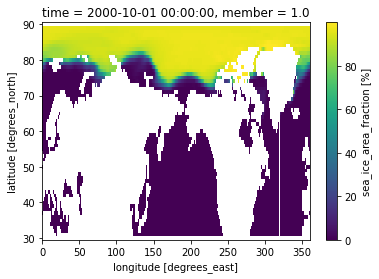

In [7]:
#quickly plot to make sure you've got the correct dataset
CESM_SIC_regrid['sic'].sel(member=1).sel(time='2000').plot()

## 2 Download observations of Northern Hemisphere sea ice concentration, from Google Drive

In [139]:
#download the file NSIDC_September_SIC_masked_2000_2020.nc
#now open it with xarray and have a look at it
NSIDC_sep = xr.open_dataset('NSIDC_September_SIC_masked_2000_2020.nc')

In [141]:
NSIDC_sep

<xarray.Dataset>
Dimensions:                  (time: 42, xgrid: 304, ygrid: 448)
Coordinates:
  * time                     (time) datetime64[ns] 1979-09-01 ... 2020-09-01
  * ygrid                    (ygrid) float32 5.838e+06 5.812e+06 ... -5.338e+06
  * xgrid                    (xgrid) float32 -3.838e+06 -3.812e+06 ... 3.738e+06
    latitude                 (ygrid, xgrid) float64 ...
    longitude                (ygrid, xgrid) float64 ...
Data variables:
    seaice_conc_monthly_cdr  (time, ygrid, xgrid) float32 ...

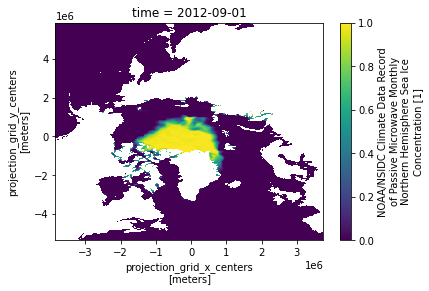

In [142]:
#plot the variable: seaice_conc_monthly_cdr, for 2012
NSIDC_sep['seaice_conc_monthly_cdr'].sel(time='2012').plot()

## 3 Regrid

In [88]:
#regrid NSIDC_September_SIC_masked_2000_2020.nc using Regrid_1x1_deg_30N.txt to make an output file NSIDC_September_SIC_masked_2000_2020_regrid.nc
!cdo remapbil,Regrid_1x1_deg_30N.txt, NSIDC_September_SIC_masked_2000_2020.nc NSIDC_September_SIC_masked_2000_2020_regrid.nc

Warning (cdfScanVarAttr): Inconsistent data type for attribute seaice_conc_monthly_cdr:valid_range, ignored!
Warning (cdfScanVarAttr): NetCDF: Variable not found - projection
cdo    remapbil: Bilinear weights from curvilinear (304x448) to lonlat (361x61) grid, with source mask (0)
cdo    remapbil:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91cdo    remapbil: Bilinear weights from curvilinear (304x448) to lonlat (361x61) grid, with source mask (67262)
cdo    remapbil:                        1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 91cdo    remapbil: Bilinear weights from curvilinear (304x448) to lonlat (361x61) grid, with source mask (67213)
cdo    remapbil:                        1 1 1 1 1 1 1 1 

In [ ]:
#if you can't get CDO to work, please download NSIDC_September_SIC_masked_2000_2020_regrid.nc from Google Drive

In [143]:
#open your dataset
regridded_NSIDC = xr.open_dataset('NSIDC_September_SIC_masked_2000_2020_regrid.nc')

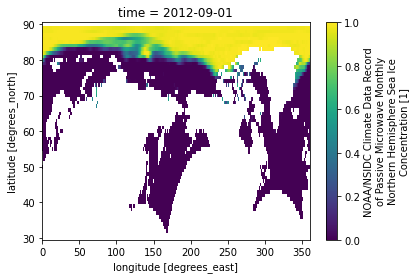

In [147]:
#plot your dataset for 2012, again use the 'seaice_conc_monthly_cdr' variable
regridded_NSIDC['seaice_conc_monthly_cdr'].sel(time='2012').plot()

## 4 Compute differences

In [151]:
#load the polar plotting function from this morning
def circular_polar_plot(data, lat_min, colors, title_, no_col_bar=False, 
                        cbar_label=False, levels_=False, cbar_levels_=False, 
                        extend_kw=False, horizontal=False):
    
    '''
    This function requires an input of an xarray dataarray with lat/lon and a third varaible
    '''
    
    #define the overall figure charachteristics
    fig = plt.figure(figsize=[8,8]) #set the size of the figure
    ax = fig.add_subplot(projection = ccrs.NorthPolarStereo(central_longitude=0)) #define the axes in terms of the polar projection
    ax.set_extent((-180,180,int(lat_min),90), ccrs.PlateCarree()) #only include data above the minimum latitude
    
    #make the plot circular using matplotlib.path
    theta = np.linspace(0, 2*np.pi, 100) 
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T #matrix transpose
    circle = mpath.Path(verts * radius + center) #this is now a circle boundary defined in matplotlib
    ax.set_boundary(circle, transform=ax.transAxes) #cut the plot at the circle boundary
    
    if no_col_bar: #we don't include a colorbar if this argument is True
        data.plot(ax=ax,cmap=str(colors), add_colorbar=False, add_labels=False, transform=ccrs.PlateCarree())
    else:
        fig.subplots_adjust(right=0.87) #make space at the right side of the plot for the colorbar
        plotting = data.plot(ax=ax, cmap=str(colors), add_colorbar=False, transform=ccrs.PlateCarree(), levels=levels_, add_labels=False)

        ####################################### define the colorbar ############################################
        if horizontal: #=True means we want the colobar horizontal
            orient = 'horizontal'
            cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.04]) #this is x,y position of the colorbar and length and height
        else:
            orient = 'vertical'
            cbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])
        
        #define whether the colorbar should be capped, default if no 'extend_kw' keyword is for both caps to be there so 'extend=both'
        if extend_kw:
             cb = fig.colorbar(plotting, cax=cbar_ax, ticks=cbar_levels_, spacing='uniform', extend=extend_kw, orientation=orient)
        else:
             cb = fig.colorbar(plotting, cax=cbar_ax, ticks=cbar_levels_, spacing='uniform', extend='both', orientation=orient)
        
        #set the label and label size of the colorbar
        if horizontal:
            cb.ax.set_xlabel(str(cbar_label), fontsize=20)
        else:
            cb.ax.set_ylabel(str(cbar_label), fontsize=20)
    
        cb.ax.tick_params(labelsize=20) #set the tick size on the colobar
        #####################################################################################################
    
    #add details to the figure after the data is plotted
    ax.coastlines() #add coastlines
    ax.gridlines() #add gridlines
    ax.set_title(str(title_), fontsize=20) #set the title and fontzise
    ax.set_facecolor('0.5') #make the background (usually land) gray

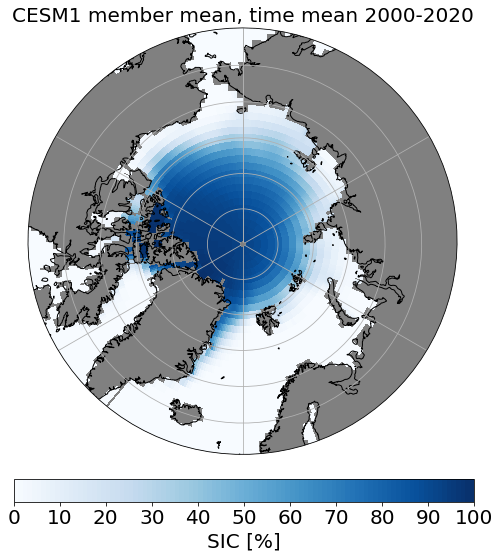

In [152]:
#plot CESM member mean, time mean
#this is an example of how to do this
circular_polar_plot(CESM_sep['sic'].mean('member').mean('time'), 60, 'Blues', 'CESM1 member mean, time mean 2000-2020',
                        cbar_label='SIC [%]', levels_=np.arange(0,101,1), cbar_levels_=np.arange(0,101,10), 
                        extend_kw='neither', horizontal=True)

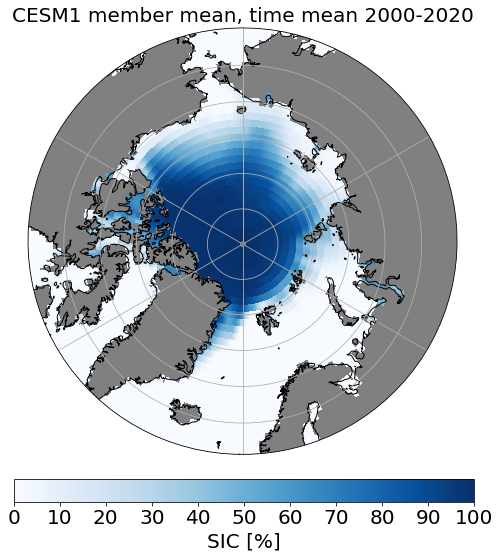

In [108]:
#adjust the function as above to plot NSIDC time mean (note you need to multiply by 100!)
circular_polar_plot(regridded_NSIDC['seaice_conc_monthly_cdr'].mean('time')*100, 60, 'Blues', 'CESM1 member mean, time mean 2000-2020',
                        cbar_label='SIC [%]', levels_=np.arange(0,101,1), cbar_levels_=np.arange(0,101,10), 
                        extend_kw='neither', horizontal=True)

In [154]:
#calculate the difference between the two, and save as a new varialbe called CESM_diff (CESM member mean, time mean - NSIDC time mean)
CESM_diff = CESM_sep['sic'].mean('member').mean('time') - regridded_NSIDC['seaice_conc_monthly_cdr'].mean('time')*100

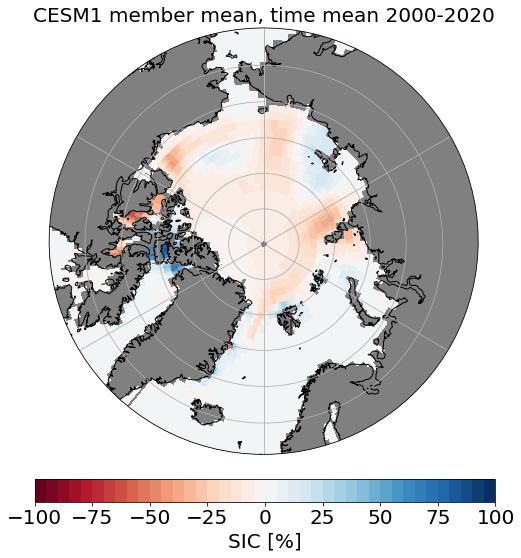

In [155]:
#plot the difference
circular_polar_plot(CESM_diff, 60, 'RdBu', 'CESM1 member mean, time mean 2000-2020',
                        cbar_label='SIC [%]', levels_=np.arange(-100,101,5), cbar_levels_=np.arange(-100,101,25), 
                        extend_kw='neither', horizontal=True)

## 5 Plot the standard deviations

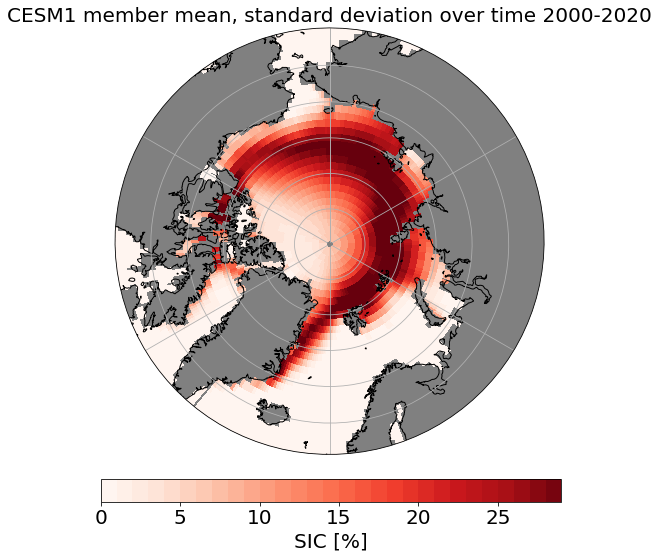

In [124]:
#plot standard deviation (along the time coordinate) for CESM (member mean)
#N.B we want to calculate standard deviation first, and then take the average across members 
circular_polar_plot(CESM_sep['sic'].std('time').mean('member'), 60, 'Reds', 'CESM1 member mean, standard deviation over time 2000-2020',
                        cbar_label='SIC [%]', levels_=np.arange(0,30,1), cbar_levels_=np.arange(0,31,5), 
                        extend_kw='neither', horizontal=True)

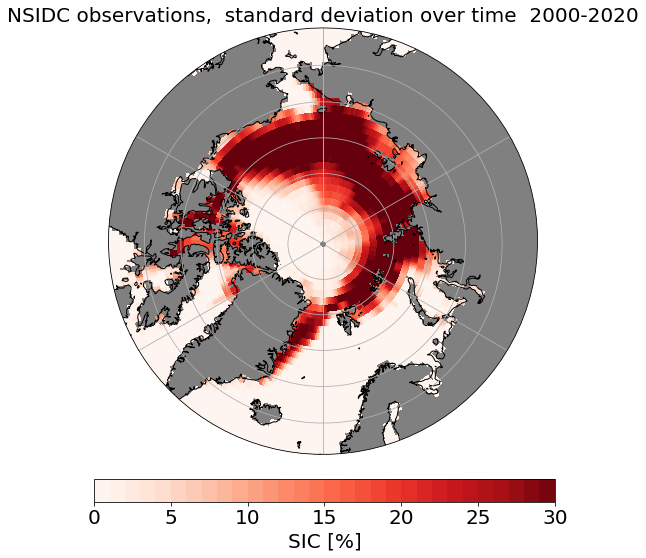

In [156]:
#plot standard deviation (along the time coordinate) for NSIDC (don't forget to multiply by 100)
circular_polar_plot(regridded_NSIDC['seaice_conc_monthly_cdr'].std('time')*100, 60, 'Reds', 'NSIDC observations,  standard deviation over time  2000-2020',
                        cbar_label='SIC [%]', levels_=np.arange(0,31,1), cbar_levels_=np.arange(0,31,5), 
                        extend_kw='neither', horizontal=True)

In [127]:
#calculate the difference in standard deviation (CESM - NSIDC), call this variable: std_diff 
std_diff = CESM_sep['sic'].std('time').mean('member') - regridded_NSIDC['seaice_conc_monthly_cdr'].std('time')*100

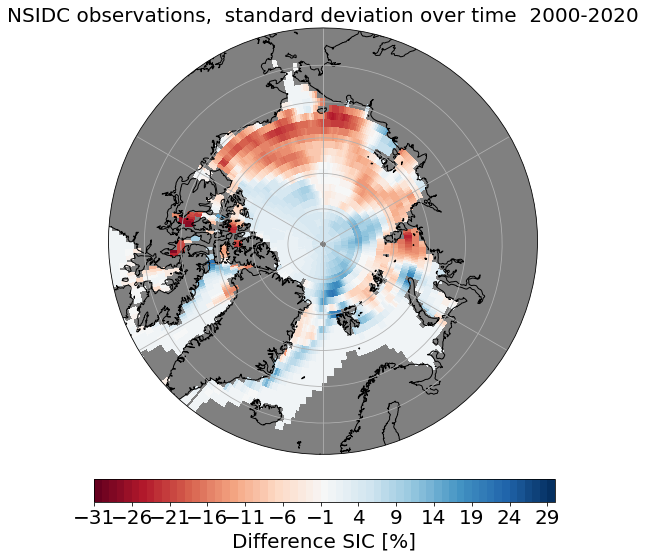

In [135]:
#plot std_diff by using std_diff.where(abs(std_diff)>0) and remember to change the levels_ argument to include negative numbers
circular_polar_plot(std_diff.where(abs(std_diff)>0), 60, 'RdBu', 'NSIDC observations,  standard deviation over time  2000-2020',
                        cbar_label='Difference SIC [%]', levels_=np.arange(-31,31,1), cbar_levels_=np.arange(-31,31,5), 
                        extend_kw='neither', horizontal=True)

# Extension: Adding to the CanESM2 SIA ensemble figure from this morning
## a Calculate the SIA in CESM

In [157]:
#compute the SIA for the ensemble members in CESM from file CESM_LE_SIC_2000_2020_09_NH.nc
#note it's always best to do calculations on the native grid first, you'll need the areacello file to do the weighting
#the areacello file you'll need is: areacello_fx_CESM1-CAM5_rcp85_r0i0p0.nc
CESM_SIC = xr.open_dataset('CESM_LE_SIC_2000_2020_09_NH.nc')

In [159]:
CESM_SIC['sic']

<xarray.DataArray 'sic' (member: 40, time: 21, j: 112, i: 320)>
[30105600 values with dtype=float32]
Coordinates:
  * i        (i) int32 1 2 3 4 5 6 7 8 9 ... 312 313 314 315 316 317 318 319 320
  * j        (j) int32 273 274 275 276 277 278 279 ... 379 380 381 382 383 384
  * time     (time) object 2000-10-01 00:00:00 ... 2020-10-01 00:00:00
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 32 33 34 35 36 37 38 39 40
Attributes:
    standard_name:   sea_ice_area_fraction
    long_name:       sea_ice_area_fraction
    units:           %
    comment:         Created using NCL code
    original_units:  %
    original_name:   aice
    cell_methods:    time: mean (interval: 1 month)
    grid_loc:        2111
    time:            675281.0

In [161]:
CESM_areacello = xr.open_dataset('areacello_fx_CESM1-CAM5_rcp85_r0i0p0.nc')

In [162]:
CESM_areacello

<xarray.Dataset>
Dimensions:       (i: 320, j: 384, vertices: 4)
Coordinates:
  * j             (j) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
  * i             (i) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
    lat           (j, i) float32 ...
    lon           (j, i) float32 ...
Dimensions without coordinates: vertices
Data variables:
    lat_vertices  (j, i, vertices) float32 ...
    lon_vertices  (j, i, vertices) float32 ...
    areacello     (j, i) float32 ...
Attributes: (12/35)
    institution:                  NSF/DOE NCAR (National Center for Atmospher...
    institute_id:                 NSF-DOE-NCAR
    experiment_id:                rcp85
    source:                       CESM1-CAM5
    model_id:                     CESM1-CAM5
    forcing:                      N/A
    ...                           ...
    table_id:                     Table fx (12 January 2012) 3b84a801563e3872...
    title:                        CESM1-CAM5 model output prepared for CMIP5 ...
    parent_experiment:            N/A
    modeling_realm:               ocean
    realization:                  0
    cmor_version:                 2.8.1

In [164]:
CESM_weighted = CESM_SIC['sic'] * CESM_areacello['areacello']

In [170]:
CESM_weighted

<xarray.DataArray (member: 40, time: 21, j: 112, i: 320)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * j        (j) int64 273 274 275 276 277 278 279 ... 379 380 381 382 383 384
  * i        (i) int32 1 2 3 4 5 6 7 8 9 ... 312 313 314 315 316 317 318 319 320
  * time     (time) object 2000-10-01 00:00:00 ... 2020-10-01 00:00:00
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 32 33 34 35 36 37 38 39 40
    lat      (j, i) float32 26.71 26.71 26.71 26.71 ... 72.21 72.2 72.19 72.19
    lon      (j, i) float32 320.6 321.7 322.8 323.9 ... 318.5 318.9 319.4 319.8

In [171]:
#sum the weighted sea ice concentrations
CESM_SIA = CESM_weighted.sum('i').sum('j')

In [220]:
#change the time from cftime to np.datetime64 so you can plot time series
new_time = []
for i in (CESM_SIA['time']): #i is each date, we will then use the charachters within each date to change to np.datetime64
    new_time.append(np.datetime64(str(i.values)[:4]+'-'+str(i.values)[5:7].zfill(2)+'-'+str(i.values)[8:10]+'T'+str(i.values)[11:13].zfill(2)+':00:00.000'))
    
SIA_CESM_new_time = CESM_SIA.copy()
SIA_CESM_new_time['time'] = new_time

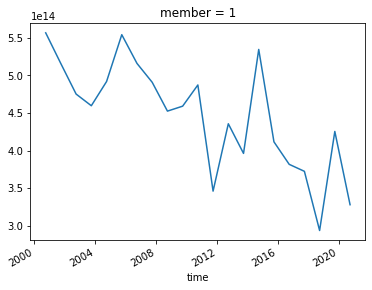

In [221]:
#now check that the data will plot with the new times
SIA_CESM_new_time.sel(member=1).plot()

In [261]:
#divide by 10^14 to get into million square km from square m
SIA_CESM_new_time = SIA_CESM_new_time/1e14 

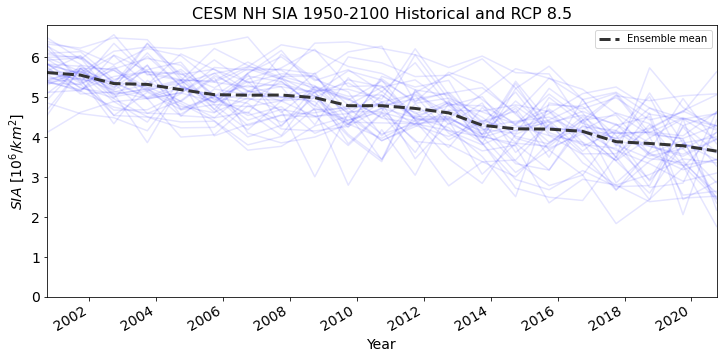

In [262]:
#remake the plot at the end of section 1 from yesterday, and add in the data you've just made for CESM
plt.figure(figsize=[12,5])

for mem_ in np.arange(1,41,1):
    SIA_CESM_new_time.sel(member=mem_).plot(c='b',alpha=0.1)

SIA_CESM_new_time.mean('member').plot(c='0.2', linestyle='--', linewidth=3, label='Ensemble mean')
    
plt.ylim(bottom=0)
plt.xlim(SIA_list_new_time['time'].min().values, SIA_list_new_time['time'].max().values)
plt.ylabel(r'$SIA \ [10^6 / km^2]$', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);
plt.legend();
plt.title('CESM NH SIA 1950-2100 Historical and RCP 8.5', fontsize=16);

## b Download the correct CSV file for NSIDC Sea Ice Area

In [190]:
#either use wget or copy and paste: ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/monthly/data/N_09_extent_v3.0.csv
!wget ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/monthly/data/N_09_extent_v3.0.csv

--2021-06-09 14:42:36--  ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/monthly/data/N_09_extent_v3.0.csv
           => ‘N_09_extent_v3.0.csv’
Resolving sidads.colorado.edu (sidads.colorado.edu)... 128.138.135.20
Connecting to sidads.colorado.edu (sidads.colorado.edu)|128.138.135.20|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /DATASETS/NOAA/G02135/north/monthly/data ... done.
==> SIZE N_09_extent_v3.0.csv ... 2021
==> PASV ... done.    ==> RETR N_09_extent_v3.0.csv ... done.
Length: 2021 (2.0K) (unauthoritative)

N_09_extent_v3.0.cs 100%[===================>]   1.97K  --.-KB/s    in 0s      

2021-06-09 14:42:36 (80.3 MB/s) - ‘N_09_extent_v3.0.csv’ saved [2021]



In [191]:
#open with pandas and select the 'area' and dates 2000-2020
import pandas as pd

NSIDC_SIE_SIA = pd.read_csv('N_09_extent_v3.0.csv')

In [232]:
NSIDC_SIE_SIA_np = np.array(NSIDC_SIE_SIA['   area'])

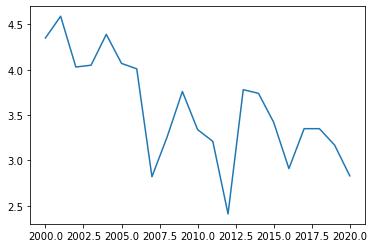

In [233]:
plt.plot(np.arange(2000,2021,1), NSIDC_SIE_SIA_np[-21:])

## c Add in the pole hole area

In [ ]:
#this dataset does not already include the pole hole area, you'll need to add this in
#note the size of this changes over the time period you're interested in, if can be found in the user guide on P23
#https://nsidc.org/data/g02135?qt-data_set_tabs=2#qt-data_set_tabs

In [248]:
#add 0.31 for 2000-2007, add 0.029 for 2008-2020
NSIDC_SIE_SIA_adjusted = NSIDC_SIE_SIA_np[-21:].copy()
NSIDC_SIE_SIA_adjusted[-13:]    = NSIDC_SIE_SIA_adjusted[-13:] + 0.029
NSIDC_SIE_SIA_adjusted[-21:-13] = NSIDC_SIE_SIA_np[-21:-13] + 0.31

In [250]:
#check the correction
NSIDC_SIE_SIA_adjusted - NSIDC_SIE_SIA_np[-21:]

array([0.31 , 0.31 , 0.31 , 0.31 , 0.31 , 0.31 , 0.31 , 0.31 , 0.029,
       0.029, 0.029, 0.029, 0.029, 0.029, 0.029, 0.029, 0.029, 0.029,
       0.029, 0.029, 0.029])

## d Add the NSIDC data to the plot of CESM, and also add in CanESM2 data

In [217]:
#open up CanESM2 SIA data
CanESM2_SIA_all_mem = xr.open_dataset('CanESM2_SIA_1950_2100_NH.nc')

In [219]:
#have a look at it
CanESM2_SIA_all_mem['sic']

<xarray.DataArray 'sic' (member: 50, time: 151)>
array([[3.068852, 3.083743, 3.351188, ..., 0.      , 0.      , 0.      ],
       [3.350398, 3.560202, 2.906779, ..., 0.      , 0.      , 0.      ],
       [3.645076, 3.770811, 3.686821, ..., 0.      , 0.      , 0.      ],
       ...,
       [3.178785, 2.31019 , 3.267918, ..., 0.      , 0.      , 0.      ],
       [3.313511, 3.704967, 3.809973, ..., 0.      , 0.      , 0.      ],
       [4.37062 , 3.308909, 3.827422, ..., 0.      , 0.      , 0.      ]],
      dtype=float32)
Coordinates:
  * time     (time) object 1950-09-16 00:00:00 ... 2100-09-16 00:00:00
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 42 43 44 45 46 47 48 49 50
Attributes:
    Description:  Northern hemishpere sea ice area for years 1950-2100 for al...
    Units:        million square km
    Timestamp:    22:10 UTC Thu 2021-05-20
    Source:       Data - /glade/collections/cdg/data/CLIVAR_LE/canesm2_lens/O...

In [251]:
#change the time to np.datetime64
new_time = []
for i in (CanESM2_SIA_all_mem['time']): #i is each date, we will then use the charachters within each date to change to np.datetime64
    new_time.append(np.datetime64(str(i.values)[:4]+'-'+str(i.values)[5:7].zfill(2)+'-'+str(i.values)[8:10]+'T'+str(i.values)[11:13].zfill(2)+':00:00.000'))
    
SIA_CanESM2_new_time = CanESM2_SIA_all_mem.copy()
SIA_CanESM2_new_time['time'] = new_time

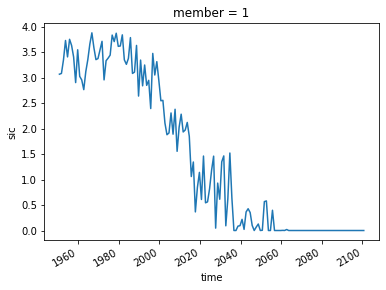

In [256]:
SIA_CanESM2_new_time['sic'].sel(member=1).plot()

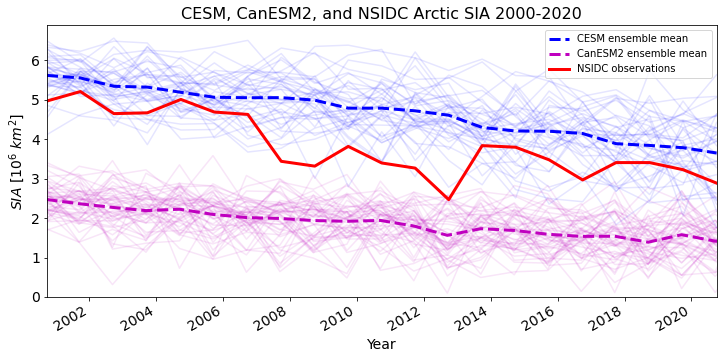

In [268]:
#now you should have CESM, CanESM2 and NSIDC datat, plot them all on the same plot
plt.figure(figsize=[12,5])

for mem_ in np.arange(1,51,1):
    SIA_CanESM2_new_time['sic'].sel(member=mem_).plot(c='m',alpha=0.1)
    
for mem_ in np.arange(1,41,1):
    SIA_CESM_new_time.sel(member=mem_).plot(c='b',alpha=0.1)

SIA_CESM_new_time.mean('member').plot(c='b', linestyle='--', linewidth=3, label='CESM ensemble mean')
SIA_CanESM2_new_time['sic'].mean('member').plot(c='m', linestyle='--', linewidth=3, label='CanESM2 ensemble mean')

plt.plot(SIA_CESM_new_time['time'], NSIDC_SIE_SIA_adjusted[-21:], c='r', linewidth=3, label='NSIDC observations')
    
plt.ylim(bottom=0)
plt.xlim(SIA_list_new_time['time'].min().values, SIA_list_new_time['time'].max().values)
plt.ylabel(r'$SIA \ [10^6 \ km^2]$', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);
plt.legend();
plt.title('CESM, CanESM2, and NSIDC Arctic SIA 2000-2020', fontsize=16);